## Additional remarks about NeRFs

It is very hard to describe the whole NeRF pipeline in detail within a single chapter. The explanations above are important to understand the basic concepts and similar if not identical in every NeRF model. However, some additional tricks are needed to obtain a well performing model.

First of all, it is necesarry to encode input signals in order to capture high-frequency variations in colour and geometry. The practice of encoding inputs before passing them through a neural network is not unique to the NeRF domain but also widely adopted in other ML domains like for example Natural Language Processing (NLP). A very simple encoding where we map the inputs to a higher dimensional space, enabling us to capture high frequency variations in scene parameters could look as follows:

In [ ]:
import torch
import mediapy as media
import numpy as np


def positional_encoding(in_tensor, num_frequencies, min_freq_exp, max_freq_exp):
    """Function for positional encoding."""
    # Scale input tensor to [0, 2 * pi]
    scaled_in_tensor = 2 * np.pi * in_tensor
    # Generate frequency spectrum
    freqs = 2 ** torch.linspace(
        min_freq_exp, max_freq_exp, num_frequencies, device=in_tensor.device
    )
    # Generate encodings
    scaled_inputs = scaled_in_tensor.unsqueeze(-1) * freqs
    encoded_inputs = torch.cat(
        [torch.sin(scaled_inputs), torch.cos(scaled_inputs)], dim=-1
    )
    return encoded_inputs.view(*in_tensor.shape[:-1], -1)


def visualize_grid(grid, encoded_images, resolution):
    """Helper Function to visualize grid."""
    # Split the grid into separate channels for x and y
    x_channel, y_channel = grid[..., 0], grid[..., 1]
    # Show the original grid
    print("Input Values:")
    media.show_images([x_channel, y_channel], cmap="plasma", border=True)
    # Show the encoded grid
    print("Encoded Values:")
    num_channels_to_visualize = min(
        8, encoded_images.shape[-1]
    )  # Visualize up to 8 channels
    encoded_images_to_show = encoded_images.view(resolution, resolution, -1).permute(
        2, 0, 1
    )[:num_channels_to_visualize]
    media.show_images(encoded_images_to_show, vmin=-1, vmax=1, cmap="plasma", border=True)


# Parameters similar to your NeRFEncoding example
num_frequencies = 4
min_freq_exp = 0
max_freq_exp = 6
resolution = 128

# Generate a 2D grid of points in the range [0, 1]
x_samples = torch.linspace(0, 1, resolution)
y_samples = torch.linspace(0, 1, resolution)
grid = torch.stack(
    torch.meshgrid(x_samples, y_samples), dim=-1
)  # [resolution, resolution, 2]

# Apply positional encoding
encoded_grid = positional_encoding(grid, num_frequencies, min_freq_exp, max_freq_exp)

# Visualize result
visualize_grid(grid, encoded_grid, resolution)

The output should look something like:
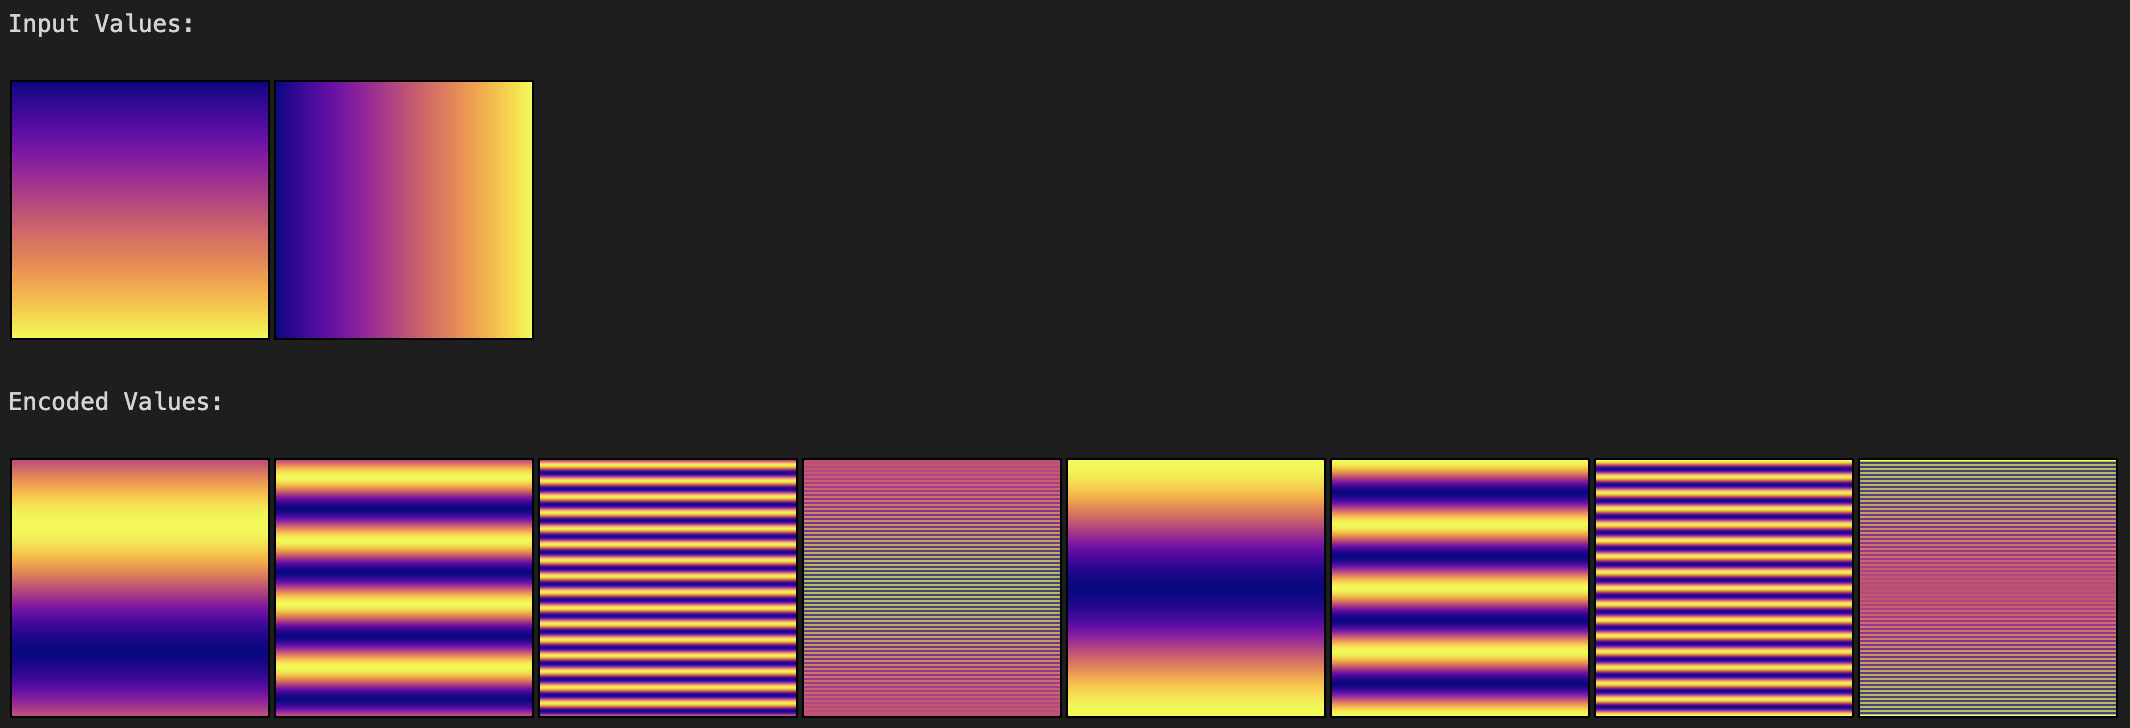

The second trick worth mentioning is that most methods use smart approaches to sample points in space. Essentially, we want to avoid sampling in regions where the scene is empty. There are various approaches to concentrate samples in regions that contribute most to the final image, but the most prominent one is to use a second network, often called proposal network so that no compute is wasted. If you are interested in the inner workings and optimisation of such a proposal network, feel free to dig into the publication of Mipnerf-360, where it was first proposed.
Train your own NeRF

To get the full experience when training your first NeRF, I recommend taking a look at the awesome Google Colab notebook from the nerfstudio team. There, you can upload images of a scene of your choice and train a NeRF. You could for example fit a model to represent your living room. 🎉🎉